In [1]:
import numpy as np
from qiskit import *
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
%matplotlib inline


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_belem')
qbackend = Aer.get_backend('qasm_simulator')

In [3]:
a_3 = '111'
matrix_3 = np.array([[0,1,1],
                     [1,0,1]])

In [4]:
a_8 = [1,0,0,0,0,0,0,1]
matrix_8 = np.array([[1,0,0,0,0,0,0,1],
                   [0,1,0,0,0,0,0,0],
                   [0,0,1,0,0,0,0,0],
                   [0,0,0,1,0,0,0,0],
                   [0,0,0,0,1,0,0,0],
                   [0,0,0,0,0,1,0,0],
                   [0,0,0,0,0,0,1,0]])

In [5]:
# below is to build the oracle for Simon's problem
def build_Uf(circuit, matrix):
    (k,n) = np.shape(matrix)
    for out in range(k):
        for inp in range(n):
            if matrix[out][inp] == 1:
                circuit.cx(n-1-inp,n-2-out+n)
    return circuit

# Function to build and return a circuit that performs the quantum operations of Simon's algorithm.
# inputs are number of input qubits and the oracle matrix associated with a given "a" value.
def build_circuit(n, matrix, barriers=False):
    input_register = QuantumRegister(n, 'input')
    output_register = QuantumRegister(n-1, 'output')
    cregister = ClassicalRegister(n, 'cregister')
    circuit = QuantumCircuit(input_register, output_register, cregister)
# the next for loop implements hadamard gates
    for i in range(n):
        circuit.h(i)
    if barriers:
        circuit.barrier(input_register)
        circuit.barrier(output_register)
#function that builds the oracle itself
    build_Uf(circuit, matrix)
    if barriers:
        circuit.barrier(input_register)
        circuit.barrier(output_register)
# We now measure the output qubits
    for i in range(n-1):
        circuit.measure(output_register[i], cregister[i])
    if barriers:
        circuit.barrier(output_register)
# We apply H to every input qubit and them measure it
    for i in range(n):
        circuit.h(i)
    if barriers:
        circuit.barrier(input_register)
    for i in range(n):
        circuit.measure(input_register[i], cregister[i])
    return circuit

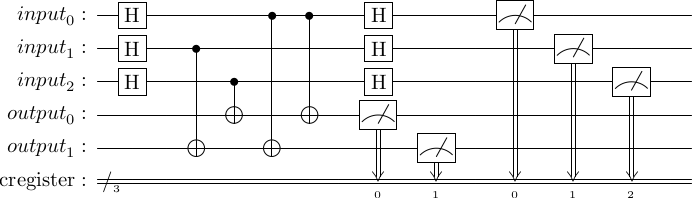

In [6]:
# This is Simon's circuit associated with "a" value of 111
build_circuit(3, matrix_3, barriers=True).draw(output='latex', plot_barriers=False)

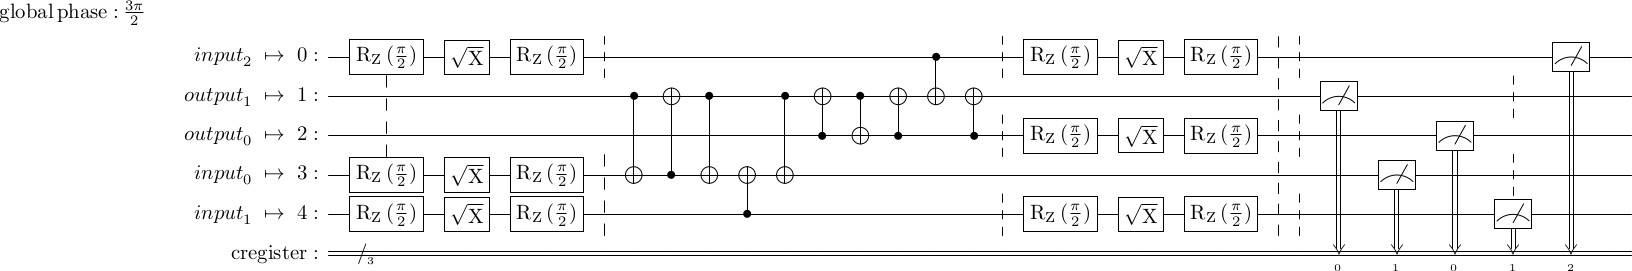

In [9]:
# This is the transpiled version of the above circuit
circuit3_t = transpile(build_circuit(3, matrix_3, barriers=True), backend=backend)
circuit3_t.draw(output='latex', idle_wires=False)

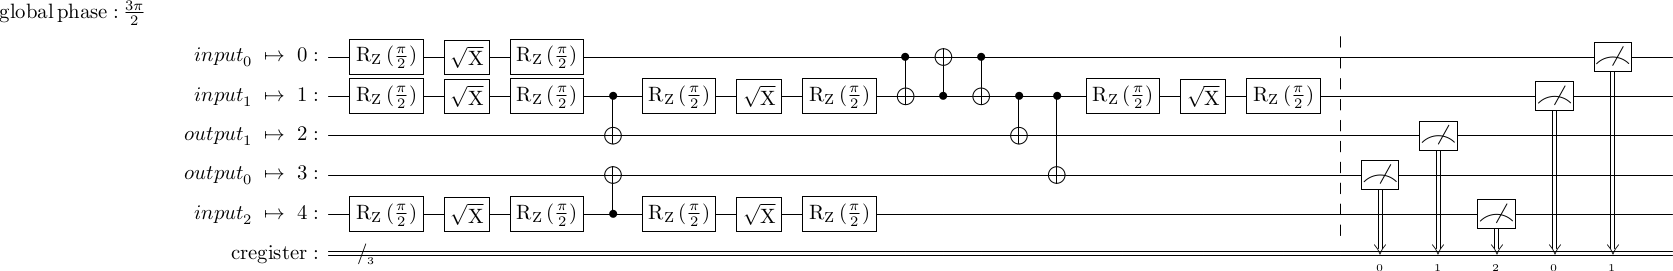

In [10]:
# again, another form of the transpiled circuit
circuit3_transpiled = transpile(build_circuit(3, matrix_3), backend)
circuit3_transpiled.draw(output='latex')

In [7]:
# this allows us to choose what QC we want to use. imbq_belem is a 5 qubit QC while ibmq_oslo is a 7 qubit QC
real_computer = False
if real_computer:
    IBMQ.load_account()
    provider = IBMQ.get_provider(group='open')
    backend = provider.get_backend('ibmq_belem')
    backend7 = provider.get_backend('ibm_oslo')
else:
    backend = Aer.get_backend('qasm_simulator') 

In [8]:
# we set the parameters of the circuit here
n = 3
matrix = matrix_3
m = 6

circuit = build_circuit(n, matrix)

In [9]:
# this just executes the Simon's algorithm 
job = execute(circuit, backend, shots=m, memory=True)
result = job.result()

In [10]:
# this is the results we obtain
# these outputs are those outputs that satisfy the dot product condition
state = result.get_counts(circuit)
print(state)

{'011': 2, '000': 1, '110': 2, '101': 1}


In [11]:
# this is the post-classical processing part of Simon's algorithm
# via brute force, we test all the 2^n possible values of "a"

def find_a(state):
    # This figures out the  n from the state information given which we ran in the previous code.
    n_ = len(next(iter(state)))
    # below is a  list to hold the possible "a" values that could work
    possible_as = []
    for i in range(1,2**n):
        it_works = True
        for key in state:
            if bitwise_dot(i, int(key,2)) == 1:
                it_works = False     
        if it_works:
            possible_as.append("{0:0{digits}b}".format(i, digits=n_))
    return possible_as

# bitwise_dot performs the dot product mod 2 for use in the find "a" function
def bitwise_dot(a, b, strings=False):
    if strings:
        a_str = a
        b_str = b
    else:
        if a < b:
            return bitwise_dot(b, a)
        a_str = "{0:0b}".format(a)
        b_str = "{0:0{digits}b}".format(b, digits=len(a_str))
    result = 0
    for i in range(len(a_str)):
        if a_str[i] == '1' and b_str[i] == '1':
            result += 1
    return result % 2

In [12]:
# as expected, we found the correct "a" value
find_a(state)

['111']

In [13]:
# we wrote the test accuracy function to test the average accuracy of the algorithm across "m"
# trials and a wrapper function 'perform experiment' to repeat such a test for a range
# of "m" values
def test_accuracy(runs, a_truth, circuit, backend=Aer.get_backend('qasm_simulator'), trials=100):
    successes = 0
    for i in range(trials):
        job = execute(circuit, backend, shots=runs, memory=True)
        result = job.result()
        state = result.get_counts(circuit)
        possible_as = find_a(state)
        if a_truth in possible_as:
            successes += 1/len(possible_as)
    return successes / trials

#performs an experiment for the n=6 circuits 
def perform_experiment6(runs_min, runs_max, a_val_num=16, backend=Aer.get_backend('qasm_simulator'), 
                        trials_each=10, transpiled=False, transpile_backend = Aer.get_backend('qasm_simulator')):
    shot_x = []
    success_y = []
    for shots in range(runs_min, runs_max+1):
        shot_x.append(shots)
        percentages = []
        for i in range(a_val_num):
            (a, a_matrix) = a_value_pairs[i]
            a_circuit = build_circuit(6, a_matrix)
            if transpiled:
                a_circuit=transpile(a_circuit, transpile_backend)
            percentages.append(test_accuracy(shots, a, a_circuit, backend=backend, trials=trials_each))
        success_y.append(np.mean(percentages))
    return (shot_x, success_y)

#performs an experiment for n=3 or n=8. Can be called for n=6, too, but it will just call perform_experiment6().
def perform_experiment(n, runs_min, runs_max, a_val_num=16, backend=Aer.get_backend('qasm_simulator'), 
                       trials_each=10, transpiled=False, transpile_backend = Aer.get_backend('qasm_simulator')):
    if n == 6:
        return perform_experiment6(runs_min, runs_max, a_val_num = a_val_num, backend=backend, 
                                   trials_each=trials_each, transpiled=transpiled)
    shot_x = []
    success_y = []
    expected_a = ''
    if n == 3:
        expected_a = '111'
        matrix = matrix_3
    elif n == 8:
        expected_a = '10000001'
        matrix = matrix_8
    circuit = build_circuit(n, matrix, barriers=False)
    if transpiled:
        circuit = transpile(circuit, transpile_backend)
    for shots in range(runs_min, runs_max+1):
        shot_x.append(shots)
        success_y.append(test_accuracy(shots, expected_a, circuit, backend=backend, trials=trials_each))        
    return (shot_x, success_y)

Text(0, 0.5, 'Chance of Success $P$')

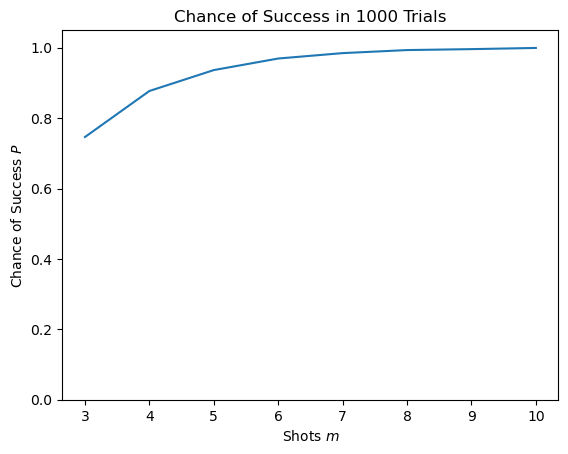

In [14]:
#Parameters for testing
# n value
n = 3
# matrix to use
matrix = matrix_3
# circuit to run (unnecessary for n=)
#  m value to start from
min_m = 3
#  m value to end at
max_m = 10
#  number of trials to perform for each m value
trials = 1000
#  whether or not to test the transpiled circuit. This won't change the outcome
#   if we're running on a quantum computer already. If we're running on a simulator,
#   this helps us verify that the transpiled circuit still produces the same results
#   if no errors occur in the computation.
transpiled = False
#  the number of a values to test. This doesn't matter for n=3 and n=8,
#   for which we only have one a value, but if n=6, we have 16 to choose from. 
#   This is why we have two perform_experiment functions.
a_vals = 16

results = perform_experiment(n, min_m, max_m, backend=backend, trials_each = trials, transpiled = transpiled)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials'.format(trials))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

Text(0, 0.5, 'Chance of Success $P$')

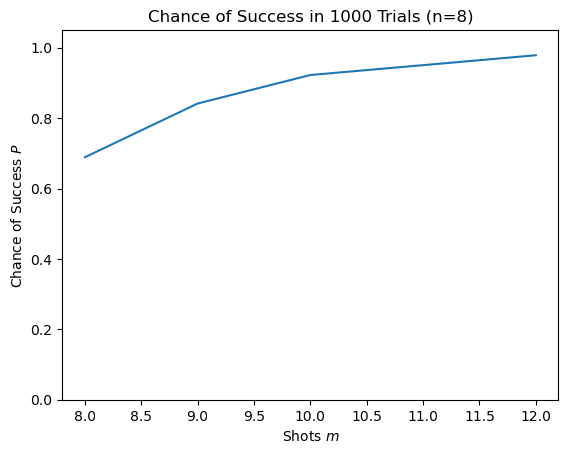

In [20]:
#Parameters for testing
# n value
n = 8
# matrix to use
matrix = matrix_8
#  m value to start from
min_m = 8
#  m value to end at
max_m = 12
#  number of trials to perform for each m value
trials = 1000
#  whether or not to test the transpiled circuit. This won't change the outcome
#   if we're running on a quantum computer already. If we're running on a simulator,
#   this helps us verify that the transpiled circuit still produces the same results
#   if no errors occur in the computation.
transpiled = False
#  the number of a values to test. This doesn't matter for n=3 and n=8,
#   for which we only have one a value, but if n=6, we have 16 to choose from. 
#   This is why we have two perform_experiment functions.
a_vals = 16

results = perform_experiment(n, min_m, max_m, backend=backend, trials_each = trials, transpiled = transpiled)
plt.plot(*results)
plt.ylim(0,1.05)
plt.title('Chance of Success in {} Trials (n={})'.format(trials, n))
plt.xlabel(f'Shots $m$')
plt.ylabel(f'Chance of Success $P$')

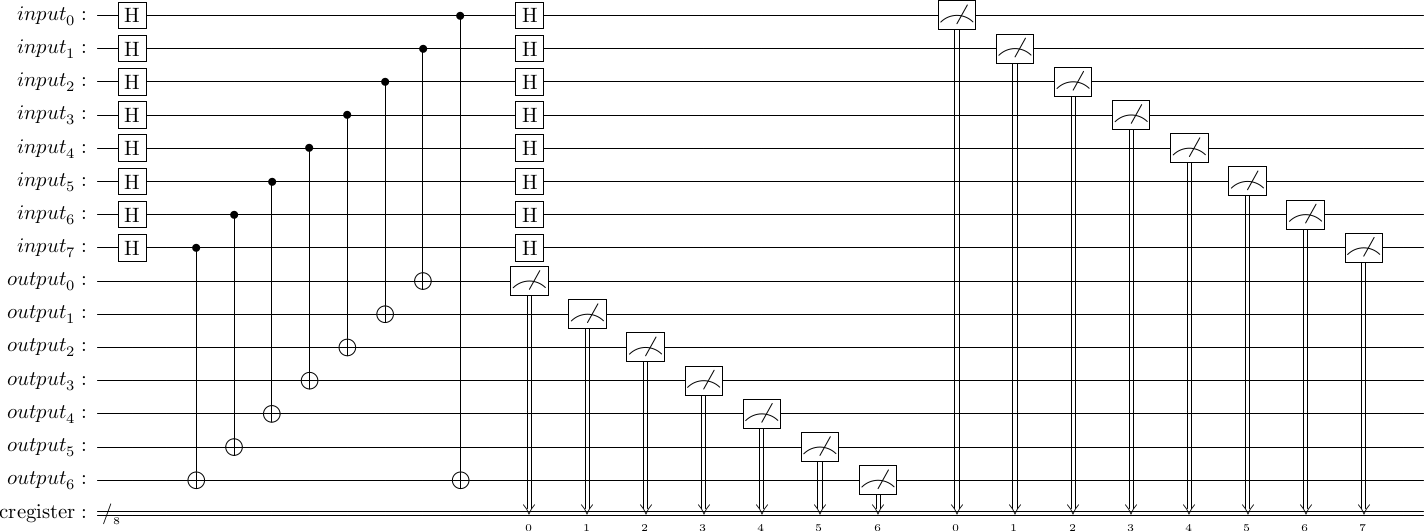

In [27]:
build_circuit(8, matrix_8, barriers=True).draw(output='latex', plot_barriers=False)

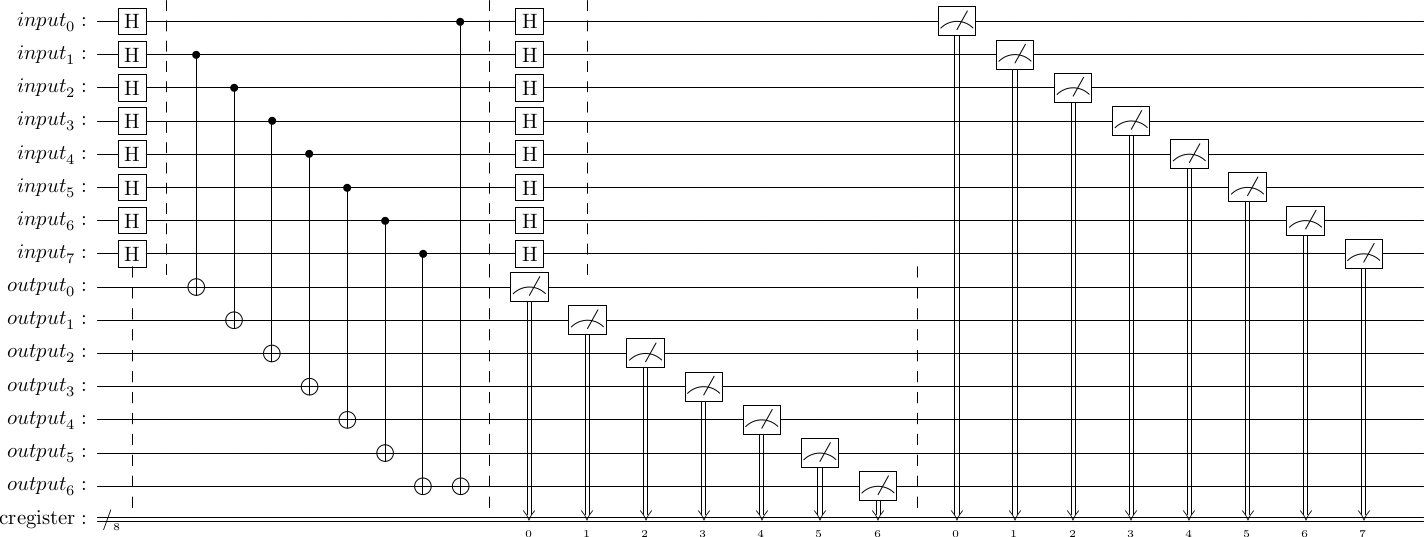

In [28]:
circuit8_t = transpile(build_circuit(8, matrix_8, barriers=True), backend=backend)
circuit8_t.draw(output='latex', idle_wires=False)